### Testing the original model with some holonomic movement

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
    
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import central_complex
import cx_basic
import cx_rate
import trials
import analysis
import plotter

save_figs=True

Visualising routes

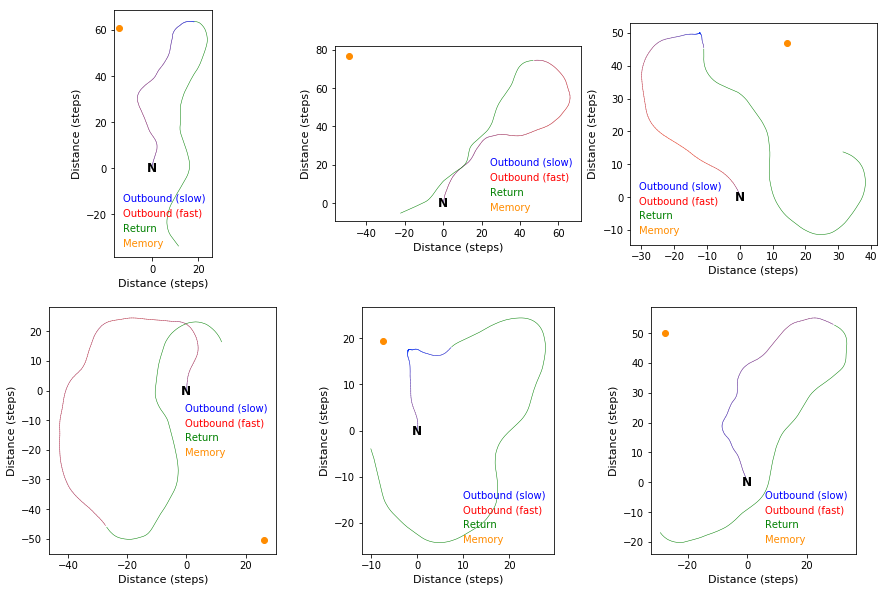

In [8]:
T_outbound = 200
T_inbound = 200

fig, ax = plt.subplots(2, 3, figsize=(15,10))
for i in range(6):
    #cxr = cx_rate.CXRate()
    cxr = cx_rate.CXRatePontin()

    h, v, log, cpu4_snapshot = trials.run_trial(T_outbound=T_outbound,
                                                T_inbound=T_inbound,
                                                cx=cxr,
                                                logging=False)
    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxr)
    cax = ax[i/3][i%3]
    plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound, plot_speed=True, 
                       ax=cax, memory_estimate=(x, y))
    #plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound,
    #                   ax=cax, memory_estimate=(x, y))
if save_figs:
    plotter.save_plot(fig, 'example_routes')

### Comparing model types
The basic model has simplified by setting no noise, perfect sinusoids etc. Some randomness is added to the steering to help prevent deadlocks when facing exactly in opposite direction.

We can decode the position directly from CPU4 by looking at the phase and amplitude of the stored sinusoid. The red dot on the plot shows the decoded position after 1000 steps.

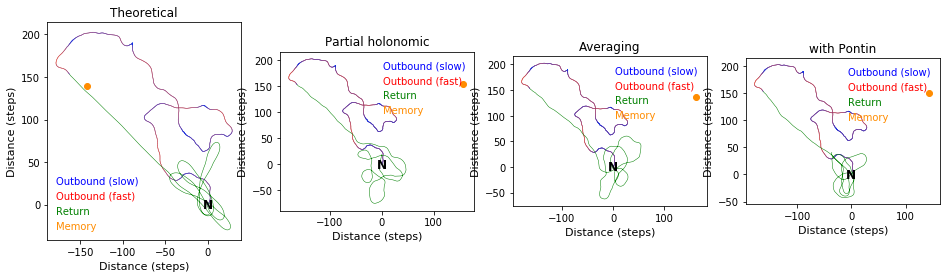

In [4]:
h_out, v_out = trials.generate_route(T=T_outbound, vary_speed=True)

noise = 0.1
T_outbound = 1500
T_inbound = 1500

cxb = cx_basic.CXBasic()
cxr = cx_rate.CXRate(noise=noise)
cxra = cx_rate.CXRateAveraging(noise=noise)  # Old model
cxrp = cx_rate.CXRatePontin(noise=noise)

cxs = [cxb, cxr, cxra, cxrp]
titles = ['Theoretical', 'Partial holonomic', 'Averaging', 'with Pontin']
logs = []

fig, ax = plt.subplots(1, len(cxs), figsize=(16,4))
for i in range(len(cxs)):
    h, v, log, cpu4_snapshot = trials.run_trial(route=(h_out, v_out), cx=cxs[i], logging=True)
    logs.append(log)
    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxs[i])
    plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound,
                       title=titles[i], ax=ax[i], plot_speed=True, memory_estimate=(x, y))

You can see that the rate based model approximates the theoretical one very well, despite significant noise and misshaped tuning curves.

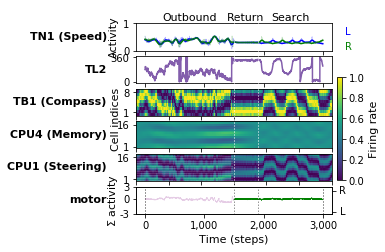

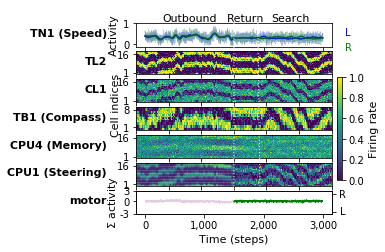

In [5]:
fig, ax = plotter.plot_traces(
        logs[0], include=['TN1', 'TL2', 'TB1', 'CPU4', 'CPU1', 'motor'])
fig, ax = plotter.plot_traces(
        logs[1], include=['TN1', 'TL2', 'CL1', 'TB1', 'CPU4', 'CPU1', 'motor'])

### Proof of concept for perfectly integrating (and steering) circuit
Let's try force some very holonomic movement.

We run three outbound paths: NorthEast, NorthWest and East.
For each the heading of the agent is varied during the outbound path.
We test the heading in the following situations:
- In direction of motion (to test non-holonomic integration)
- Facing North (within 45 degree of first two paths)
- Facing South (outside 45 degree of all paths)
- Facing North-North-East (biased but within 45 degree of NorthEast path)
- Random
- Bounded Random (within +- 45 degree of heading)


In [6]:
def check_biases(cx):
    T_outbound = 800
    T_inbound = 1000  # We allow the return route to be a little longer so search is visible.

    v_holo_NE = np.ones([T_outbound, 2]) * np.sqrt(0.5) / 4 #/2
    #v_holo_NW = np.ones([T_outbound, 2]) * np.sqrt(0.5) /2
    #v_holo_NW[:,0] *= -1
    v_holo_E = np.ones([T_outbound, 2])
    #v_holo_E[:,1] = 0
    v_holo = [v_holo_NE]
    
    random_angle_len = 25

    fig, ax = plt.subplots(2,3, figsize=(9,6))

    heading_labels = ['Dir of motion', 'North', 'South',
                      'North-North-East','Random', 'Bounded random']
    for i in range(len(v_holo)):
        movement_angle = np.arctan2(v_holo[i][0,0], v_holo[i][0,1])
        h_holo = [movement_angle * np.ones(T_outbound),
                  np.zeros(T_outbound),
                  np.pi * np.ones(T_outbound),
                  np.pi / 8.0 * np.ones(T_outbound),
                  np.repeat(2.0 * np.pi * np.random.random(T_outbound / random_angle_len), random_angle_len),
                  #2.0 * np.pi * np.random.random(T_outbound),
                  movement_angle - np.pi / 4.0 + np.pi / 2.0 * np.random.random(T_outbound)]

        for j in range(len(h_holo)):
            h, v, log, cpu4_snapshot = trials.run_trial(route=(h_holo[j], v_holo[i]),
                                                        T_outbound=T_outbound,
                                                        T_inbound=T_inbound,
                                                        cx=cx,
                                                        logging=True,
                                                        vary_speed=False)
            x, y = analysis.compute_location_estimate(cpu4_snapshot, cx)
            
            plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound,
                               ax=ax[j/3][j%3], memory_estimate=(x, y), labels=False,
                               plot_heading=True, title=heading_labels[j])

    #for i, label in enumerate(heading_labels):
    #    fig.text(0.05, 0.84-i*0.13, label, va='center', rotation='vertical')
    return fig

#### Fully holonomic theoretical model
Test on theoretically perfect model. Homes well in any situation.

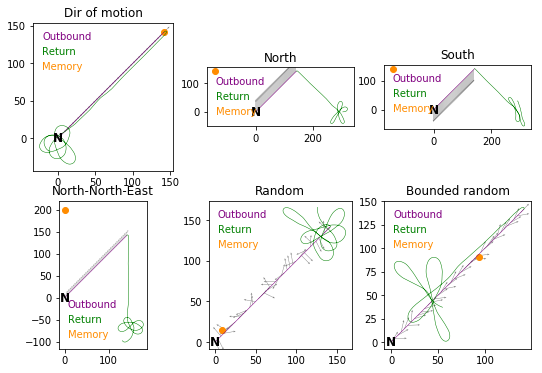

In [7]:
cxb = cx_basic.CXBasic()  # Full holonomic but more speculative memory
fig = check_biases(cxb)
if save_figs:
    plotter.save_plot(fig, 'holonomic_movement_basic_fully_holonomic')

#### Partially holonomic model
Integrates correctly for holonomic movement with heading of up to +- 45 degrees from direction of motion. Fails completely when this angle is exceeded in a biased manner. Undershoots when done in a balanced manner.

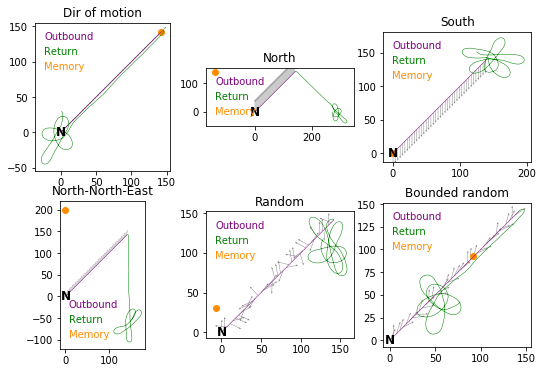

In [8]:
cxb_fw = cx_basic.CXBasicForwards()  # Partially holonomic
fig = check_biases(cxb_fw)
if save_figs:
    plotter.save_plot(fig, 'holonomic_movement_basic_partial_holonomic')

#### Forward motion only model (old model)
Integration done by averaging. Undershoots on routes with balanced right and left sideways motion, but gets direction correct. Goes in wrong direction on routes with biased sideways motion.

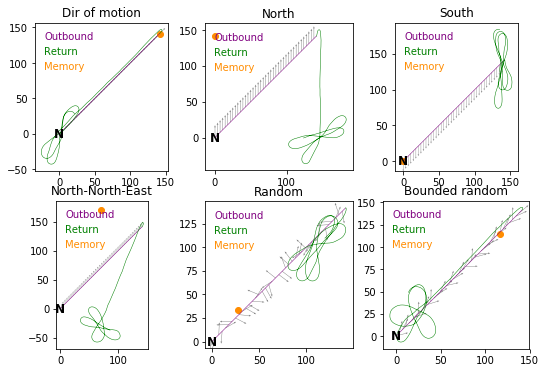

In [9]:
cxb_av = cx_basic.CXBasicAveraging()  # Non-holonomic
fig = check_biases(cxb_av)
if save_figs:
    plotter.save_plot(fig, 'holonomic_movement_basic_forward')

#### Flipped model
Here the POL preference angles for TB1 increase in a clockwise, rather than anti-clockwise along the PB. You can see how this doesn't work (and this is not related to L or R preference of motor cells). As far as I can tell there is no obvious way of avoiding this. Our model thus makes a prediction that:

- As we increase the heading angle in a clockwise fashion, the activity moves across the bridge from Right to Left

- That means as we turn the polariser in a clockwise fashion, the activity moves across the bridge from Left to Right



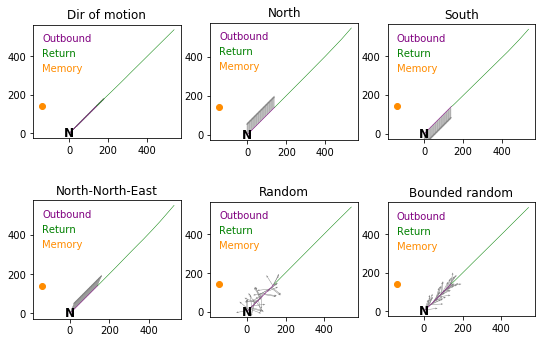

In [10]:
cxb_flipped = cx_basic.CXBasicFlipped()
fig = check_biases(cxb_flipped)
if save_figs:
    plotter.save_plot(fig, 'holonomic_movement_basic_pol_flipped')

#### Rate based model
This corresponds to the partially holonomic model

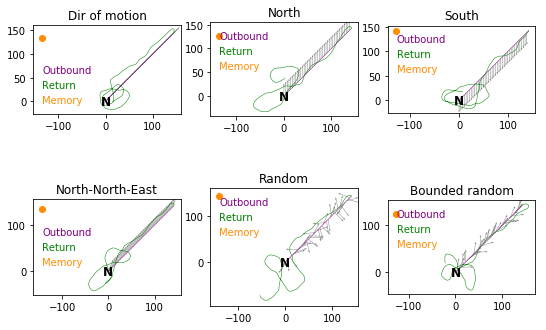

In [11]:
#cx = cx_rate.CXRate(noise=0.1)
#cx = cx_rate.CXRatePontin(noise=0.1)
#cx = cx_rate.CXRatePontinAveraging(noise=0.1)
cx = cx_rate.CXRatePontinHolonomic(noise=0.1)

fig = check_biases(cx)
if save_figs:
    plotter.save_plot(fig, 'holonomic_movement_rate_partial_holonomic')

Visualise the TN1 and TN2 activity that is capturing the sideways motion.

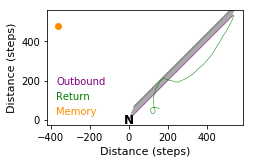

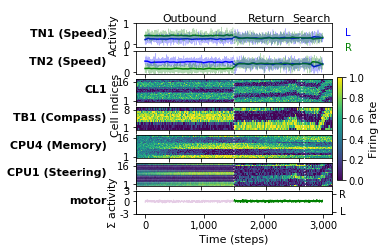

In [12]:
T_outbound = 1500
T_inbound = 1500
v = np.ones([T_outbound, 2]) * np.sqrt(0.5) / 2
h = np.pi / 8.0 * np.ones(T_outbound)

h, v, log, cpu4_snapshot = trials.run_trial(route=(h, v),
                                            logging=True,
                                            noise=0.1)
x, y = analysis.compute_location_estimate(cpu4_snapshot, cx_rate.CXRate())

plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound,
                   memory_estimate=(x, y), plot_heading=True)

plotter.plot_traces(log, T_almost_home=2600);

#### Non holonomic Rate based model
This model just does averaging of optic flow..

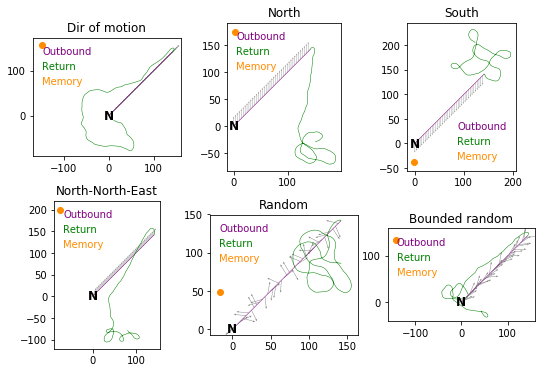

In [13]:
cx = cx_rate.CXRateAveraging(noise=0.1)
fig = check_biases(cx)
if save_figs:
    plotter.save_plot(fig, 'holonomic_movement_rate_forward')

### Visualise effect of distance on homing

In [ ]:
distances = [1000, 2000, 5000, 10000, 20000, 50000]
#cxr = cx_rate.CXRate()
cxr = cx_rate.CXRatePontin()

fig, ax = plt.subplots(2, 3, figsize=(15,10))
for i in range(6):
    h, v, log, cpu4_snapshot = trials.run_trial(T_outbound=distances[i],
                                                T_inbound=distances[i],
                                                cx=cxr,
                                                logging=True,
                                                noise=0.1)

    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxr)
    cax = ax[i/3][i%3]
    plotter.plot_route(h, v, T_outbound=distances[i],
                       T_inbound=distances[i], ax=cax,
                       memory_estimate=(x, y),
                       title="{0} Steps".format(distances[i]))
if save_figs:
    plotter.save_plot(fig, 'example_routes_distance')

### Visualise effect of speed on homing

In [ ]:
T_outbound = 1500
T_inbound = 1500

#cxr = cx_rate.CXRate()
cxr = cx_rate.CXRatePontin()

acc_factors = np.array([0.25, 0.5, 1, 1.5, 2, 2.5])
acceleration = acc_factors * trials.default_acc

fig, ax = plt.subplots(2, 3, figsize=(15,10))
for i in range(6):
    h, v, log, cpu4_snapshot = trials.run_trial(T_outbound=T_outbound,
                                                T_inbound=int(T_inbound*acc_factors[i]),
                                                cx=cxr,
                                                logging=True,
                                                acc_out=acceleration[i])
    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxr)
    cax = ax[i/3][i%3]
    plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=int(T_inbound*acc_factors[i]),
                       ax=cax, memory_estimate=(x, y), plot_speed=True,
                       title="{0} x Max speed".format(acc_factors[i]))
if save_figs:
    plotter.save_plot(fig, 'example_routes_speed')

### Visualise effect of noisy weights on homing

In [ ]:
T_outbound = 1500
T_inbound = 1500

h_out, v_out = trials.generate_route(T=T_outbound, vary_speed=True)
weight_noise = np.array([0.0, 0.01, 0.02, 0.05, 0.1, 0.2])

fig, ax = plt.subplots(2, 3, figsize=(15,10))
for i in range(6):
    #cxr = cx_rate.CXRate(weight_noise=weight_noise[i])
    cxr = cx_rate.CXRatePontin(weight_noise=weight_noise[i])
    h, v, log, cpu4_snapshot = trials.run_trial(route=(h_out, v_out),
                                                T_outbound=T_outbound,
                                                T_inbound=T_inbound,
                                                cx=cxr,
                                                logging=False)
    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxr)
    cax = ax[i/3][i%3]
    plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound,
                       ax=cax, memory_estimate=(x, y),
                       title="Weight noise: {0}".format(weight_noise[i]))
if save_figs:
    plotter.save_plot(fig, 'example_routes_weight_noise')

### Visualise effect of preference angle changes

In [ ]:
T_outbound = 1500
T_inbound = 1500

h_out, v_out = trials.generate_route(T=T_outbound, vary_speed=True)
tn_prefs = [0.0, np.pi/16, np.pi/8, 3*np.pi/16, np.pi/4, 5*np.pi/16,
            3*np.pi/8, 7*np.pi/16, np.pi/2]

fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i in range(9):
    #cxr = cx_rate.CXRate(tn_prefs=tn_prefs[i])
    cxr = cx_rate.CXRatePontin(tn_prefs=tn_prefs[i])
    h, v, log, cpu4_snapshot = trials.run_trial(route=(h_out, v_out),
                                                T_outbound=T_outbound,
                                                T_inbound=T_inbound,
                                                cx=cxr,
                                                logging=False)
    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxr)
    cax = ax[i/3][i%3]
    plotter.plot_route(
            h, v, T_outbound=T_outbound, T_inbound=T_inbound, ax=cax,
            memory_estimate=(x, y),
            title="TN pref: {0} deg".format(np.rad2deg(tn_prefs[i])))
if save_figs:
    plotter.save_plot(fig, 'example_routes_tn_preference_angles')

### TB1 bump pre-empting depending on rotation speed.

In [ ]:
T_outbound = 1500
T_inbound = 1500

h_out, v_out = trials.generate_route(T=T_outbound, vary_speed=True)
bump_shift = np.linspace(0, np.pi/4, 9)

fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i in range(9):
    #cxr = cx_rate.CXRate()
    cxr = cx_rate.CXRatePontin()
    
    h, v, log, cpu4_snapshot = trials.run_trial(route=(h_out, v_out),
                                                T_outbound=T_outbound,
                                                T_inbound=T_inbound,
                                                cx=cxr,
                                                logging=False,
                                                bump_shift=bump_shift[i])
    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxr)
    cax = ax[i/3][i%3]
    plotter.plot_route(
            h, v, T_outbound=T_outbound, T_inbound=T_inbound, ax=cax,
            memory_estimate=(x, y),
            # TODO(tomish) This is not actually the number of degrees!!!
            title="TL2 pre-empt: {0} deg".format(np.rad2deg(bump_shift[i])))
if save_figs:
    plotter.save_plot(fig, 'example_routes_bump_shift')

### Filtering flow input

In [ ]:
T_outbound = 1500
T_inbound = 1500

h_out, v_out = trials.generate_route(T=T_outbound, vary_speed=True)
flow_filtering = np.linspace(0, 30, 9)

fig, ax = plt.subplots(3, 3, figsize=(15,15))
for i in range(9):
    #cxr = cx_rate.CXRate(noise=0.05)
    cxr = cx_rate.CXRatePontin()
    h, v, log, cpu4_snapshot = trials.run_trial(route=(h_out, v_out),
                                                T_outbound=T_outbound,
                                                T_inbound=T_inbound,
                                                cx=cxr,
                                                logging=False,
                                                filtered_steps=flow_filtering[i])
    x, y = analysis.compute_location_estimate(cpu4_snapshot, cxr)
    cax = ax[i/3][i%3]
    plotter.plot_route(
            h, v, T_outbound=T_outbound, T_inbound=T_inbound, ax=cax,
            memory_estimate=(x, y),
            title="Filtered {0} steps".format(flow_filtering[i]))
if save_figs:
    plotter.save_plot(fig, 'example_routes_flow_filtered')

### Heading persistency despite obstacle avoidance

In [ ]:
T_stages = np.array([20, 80, 80, 400])
T_sideways = np.array([100, 200, 200, 0])
h_sideways = [np.ones(T_sideways[0]) * -np.pi/2,  # 100 right
              np.ones(T_sideways[1]) * np.pi/2,  # 300 left
              np.ones(T_sideways[2]) * -np.pi/2,
              np.array(0)]  # 200 right
       
v_sideways = [np.vstack([np.ones(T_sideways[0]) * -0.5,
                         np.zeros(T_sideways[0])]).T,
              np.vstack([np.ones(T_sideways[1]) * 0.5,
                         np.zeros(T_sideways[1])]).T,
              np.vstack([np.ones(T_sideways[1]) * -0.5,
                         np.zeros(T_sideways[1])]).T,
              np.array([0.0, 0.0])]

T_outbound = 1500
#cxr = cx_rate.CXRate()
cxr = cx_rate.CXRatePontin()
h_out, v_out, _ = trials.load_route(filename='route.npz')
h = h_out[:T_outbound]
v = v_out[:T_outbound]

for i in range(4):
    log_out = trials.generate_memory(h,
                                     v,
                                     cxr,
                                     logging=True)

    h_in, v_in, _ = trials.homing(
            T=T_stages[i], tb1=log_out.tb1[:,-1],
            memory=log_out.memory[:,-1], cx=cxr,
            current_heading=h[-1], current_velocity=v[-1])

    h = np.hstack([h, h_in, h_sideways[i]])
    v = np.vstack([v, v_in, v_sideways[i]])

fig, ax = plt.subplots()
plotter.plot_route(h, v, T_outbound=T_outbound, T_inbound=T_inbound, ax=ax)

xy = np.cumsum(v, axis=0)
x = xy[:,0]
y = xy[:,1]


for i in range(3):
    idx = T_outbound+np.cumsum(T_stages)[i]+np.cumsum(T_sideways)[i]
    y_pos = y[idx]-7
    
    if i % 2 == 0:
        x_pos = x[idx] + 7
        width = 400 - x_pos # Just add a big number
    else:
        x_pos = -400
        width = x[idx] - 7 - x_pos
    ax.add_patch(
        patches.Rectangle(
            (x_pos, y_pos),
            width,
            3,  # height
            color='gray'
        )
    )
    
if save_figs:
    plotter.save_plot(fig, 'obstacles')

In [ ]:
param_dict = {'n':1, 'filtered_steps':[3] , 'noise':[0.1], 'bump_shift':[np.pi/16], 'acc_out':[1.5*0.15], 'T_inbound':[int(1.5*1500)]}

errors, error_stds, min_dists, min_dist_stds = analyse(param_dict)
print errors, error_stds, min_dists, min_dist_stds

Comparing averaging to PH rate based model